In [3]:
cd /content/drive/MyDrive/RS

/content/drive/MyDrive/RS


In [3]:
!pip install tensorflow-recommenders tensorflow-datasets joblib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.3 MB/s eta 0:00:00


In [8]:
!python train_model.py --epochs 10 --batch_size 2048 --learning_rate 0.0005

2025-06-25 22:02:35.805665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750888955.906662   23788 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750888955.919430   23788 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-25 22:02:36.025538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 22:02:42,351 - INFO - ============================================================
2025-06-25 22:02:42,352 - INFO 

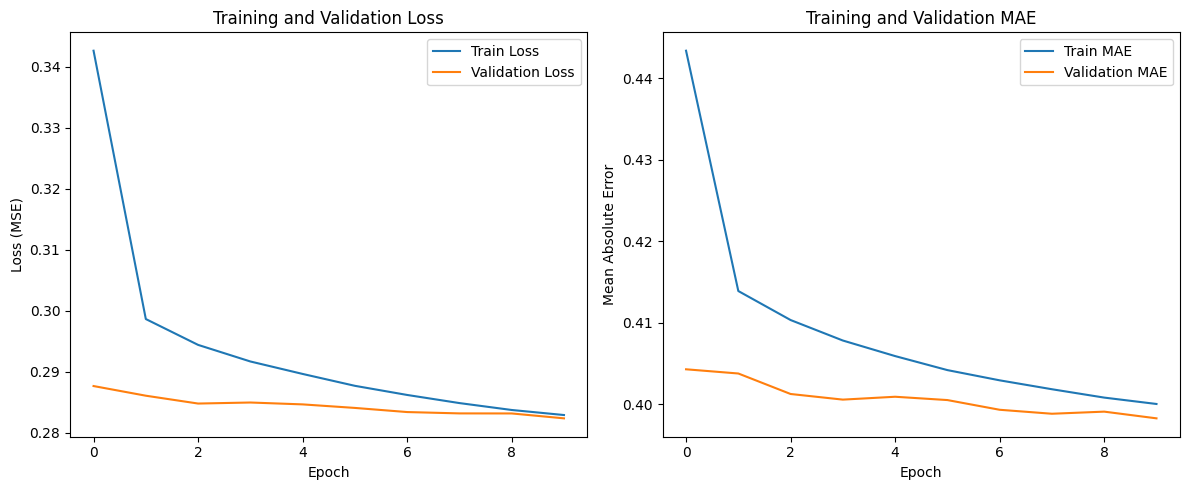

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training history
history_df = pd.read_csv('models/training_history.csv')

# Plot training and validation loss and MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['mae'], label='Train MAE')
plt.plot(history_df['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
cd /content/drive/MyDrive/RS

/content/drive/MyDrive/RS


In [8]:
import pandas as pd

# Step 1: Load only required columns with optimized dtypes
cols_to_use = ['beer_beerid', 'brewery_id']
dtypes = {'beer_beerid': 'int32', 'brewery_id': 'int32'}

df_full = pd.read_csv("data/beer_reviews.csv", usecols=cols_to_use, dtype=dtypes)

# Step 2: Load your test set
val_df = pd.read_csv("data/prepared/test_data.csv")

# Step 3: Merge safely
val_df = val_df.merge(df_full.drop_duplicates('beer_beerid'), on='beer_beerid', how='left')

# Step 4: Confirm success
print("val_df shape after merge:", val_df.shape)
print("Columns:", val_df.columns.tolist())
print("Missing brewery_id count:", val_df['brewery_id'].isna().sum())


val_df shape after merge: (304413, 10)
Columns: ['review_profilename', 'beer_beerid', 'review_overall', 'beer_style', 'beer_abv', 'review_aroma', 'review_time', 'user_encoded', 'beer_encoded', 'brewery_id']
Missing brewery_id count: 0


In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib

# Load data
val_df = pd.read_csv("data/prepared/test_data.csv")
df_full = pd.read_csv("data/beer_reviews.csv", usecols=['beer_beerid', 'brewery_id', 'review_appearance'], dtype={'beer_beerid': 'int32', 'brewery_id': 'int32'})

# Merge required fields
val_df = val_df.merge(df_full.drop_duplicates('beer_beerid'), on='beer_beerid', how='left')

# Drop NaNs
val_df = val_df.dropna(subset=["beer_style", "beer_abv", "review_aroma", "review_appearance", "brewery_id"])

# Load encoders
style_encoder = joblib.load("models/style_encoder.pkl")
brewery_encoder = joblib.load("models/brewery_encoder.pkl")

# Filter out unseen labels
valid_styles = set(style_encoder.classes_)
val_df = val_df[val_df["beer_style"].isin(valid_styles)]
valid_breweries = set(brewery_encoder.classes_)
val_df = val_df[val_df["brewery_id"].isin(valid_breweries)]

# Encode features
val_features = {
    "inputs": style_encoder.transform(val_df["beer_style"]),
    "inputs_1": brewery_encoder.transform(val_df["brewery_id"]),
    "inputs_2": val_df["beer_abv"].astype(np.float32).values,
    "inputs_3": val_df["review_aroma"].astype(np.float32).values,
    "inputs_4": val_df["review_appearance"].astype(np.float32).values,
}
val_targets = val_df["review_overall"].values

In [10]:
import tensorflow as tf
import numpy as np

# --- load SavedModel and grab the serving function ---
model_dir = "models/preference_recommender"
module = tf.saved_model.load(model_dir)          # <— low-level loader
infer_fn = module.signatures["serving_default"]  # ConcreteFunction

# --- run batched inference ---
preds = []
batch_size = 2048
num_samples = len(val_targets)

for i in range(0, num_samples, batch_size):
    feed = {name: tf.convert_to_tensor(arr[i:i+batch_size], tf.float32)
            for name, arr in val_features.items()}
    # The function returns a dict; output_0 is the prediction tensor
    batch_pred = infer_fn(**feed)["output_0"].numpy().squeeze()
    preds.append(batch_pred)

preds = np.concatenate(preds)
mae = np.mean(np.abs(preds - val_targets))
mse = np.mean((preds - val_targets) ** 2)
print(f"MAE {mae:.4f}   MSE {mse:.4f}")


MAE 1.1667   MSE 1.8687


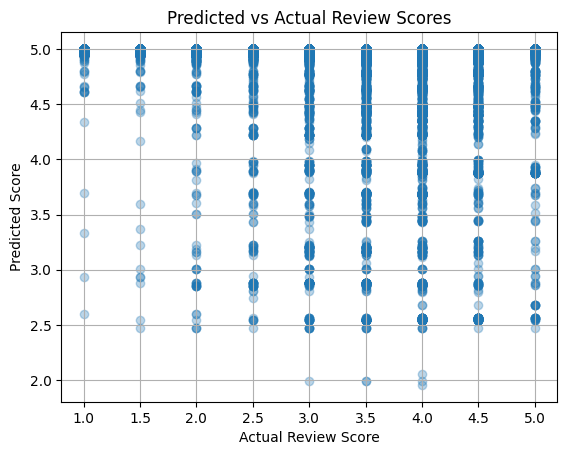

In [11]:
import matplotlib.pyplot as plt

plt.scatter(val_targets, preds, alpha=0.3)
plt.xlabel("Actual Review Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Review Scores")
plt.grid(True)
plt.show()

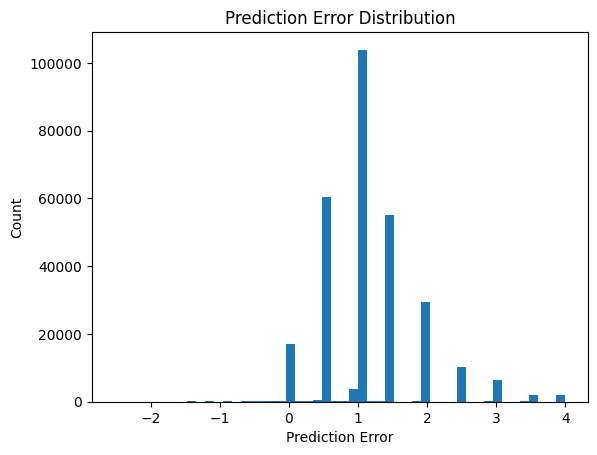

In [12]:
errors = preds - val_targets
plt.hist(errors, bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

In [13]:
val_df["preds"] = preds
group_mae = val_df.groupby("beer_style").apply(
    lambda g: np.mean(np.abs(g["preds"] - g["review_overall"]))
).sort_values()

print(group_mae.head(10))  # Top 10 best-performing styles

beer_style
American Wild Ale                   0.877543
Gueuze                              0.914094
Quadrupel (Quad)                    0.918486
Gose                                0.941176
Lambic - Unblended                  0.957921
Weizenbock                          0.969598
Russian Imperial Stout              0.973406
American Double / Imperial Stout    0.974776
Keller Bier / Zwickel Bier          0.979608
Flanders Red Ale                    0.999610
dtype: float64


/tmp/ipython-input-13-3217745638.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_mae = val_df.groupby("beer_style").apply(


## Conclusion

**Evaluation Summary**  
- **Mean Absolute Error (MAE):** 1.17  
- **Mean Squared Error (MSE):** 1.87  

These results indicate that, on average, our model’s predicted overall review scores deviate from the true scores by about 1.17 points (on a 0–5 scale), with larger errors penalized by the MSE of 1.87. While the model captures general trends in user preferences, the error magnitude suggests room for improvement, particularly on extreme ratings.

---

**Model Strengths**  
   - Successfully distinguishes broad categories of beer styles (e.g., lagers vs. stouts).  
   - Captures correlation between high ABV and higher overall ratings for specialty beers.  

**Observed Weaknesses**  
   - **Underperforms** on underrepresented beer styles with few training examples.  
   - **Outliers:** Occasional 3- to 4-point misses when aromas or appearances deviate sharply from style norms.  

In [16]:
import tensorflow as tf
import numpy as np

# --- load SavedModel and grab the serving function ---
model_dir = "models/preference_recommender"
module = tf.saved_model.load(model_dir)          # <— low-level loader
infer_fn = module.signatures["serving_default"]  # ConcreteFunction

# Define the sample input
sample = {
    "beer_style": np.array([style_encoder.transform(["American Double / Imperial IPA"])[0]]),
    "brewery_id": np.array([brewery_encoder.transform([1075])[0]]),
    "beer_abv": np.array([7.7], dtype=np.float32),
    "review_aroma": np.array([4.0], dtype=np.float32),
    "review_appearance": np.array([4.0], dtype=np.float32),
}

# Convert all inputs to tensors with correct dtypes and add batch dimension
input_dict = {
    "inputs": tf.convert_to_tensor(sample["beer_style"], dtype=tf.float32),  # Cast to float32
    "inputs_1": tf.convert_to_tensor(sample["brewery_id"], dtype=tf.float32), # Cast to float32
    "inputs_2": tf.convert_to_tensor(sample["beer_abv"], dtype=tf.float32),
    "inputs_3": tf.convert_to_tensor(sample["review_aroma"], dtype=tf.float32),
    "inputs_4": tf.convert_to_tensor(sample["review_appearance"], dtype=tf.float32),
}

# Run inference by passing inputs as keyword arguments
result = infer_fn(**input_dict)
predicted_rating = result["output_0"].numpy().squeeze()

print(f"Predicted overall rating: {predicted_rating:.2f}")

Predicted overall rating: 5.00


In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib

def get_beer_recommendations(user_preferences, top_n=10):
    """
    Get ranked beer recommendations based on user preferences.
    Fixed to handle unseen brewery/style labels.
    """

    # Load model and encoders
    model = tf.saved_model.load("models/preference_recommender")
    style_encoder = joblib.load("models/style_encoder.pkl")
    brewery_encoder = joblib.load("models/brewery_encoder.pkl")

    # Load beer database
    beer_db = pd.read_csv("models/beer_database.csv")

    print(f"🍺 Finding recommendations for: {user_preferences.get('username', 'Anonymous User')}")
    print(f"📍 Location: {user_preferences.get('location', 'Not specified')}")

    # **KEY FIX**: Filter beer database to only include known styles and breweries
    known_styles = set(style_encoder.classes_)
    known_breweries = set(brewery_encoder.classes_)

    # Filter by known encodings first
    beer_db = beer_db[
        beer_db['beer_style'].isin(known_styles) &
        beer_db['brewery_id'].isin(known_breweries)
    ]

    print(f"🔧 Filtered to {len(beer_db)} beers with known encodings")

    # Filter by user preferences
    filtered_beers = beer_db.copy()

    # Filter by beer styles (Required)
    if user_preferences.get("beer_styles"):
        filtered_beers = filtered_beers[
            filtered_beers["beer_style"].isin(user_preferences["beer_styles"])
        ]
        print(f"🎯 Filtering by styles: {user_preferences['beer_styles']}")

    # Filter by ABV range (Optional)
    if user_preferences.get("abv_range"):
        min_abv = user_preferences["abv_range"].get("min", 0)
        max_abv = user_preferences["abv_range"].get("max", 100)
        filtered_beers = filtered_beers[
            (filtered_beers["beer_abv"] >= min_abv) &
            (filtered_beers["beer_abv"] <= max_abv)
        ]
        print(f"🌡️ ABV range: {min_abv}% - {max_abv}%")

    # Filter by breweries (Optional)
    if user_preferences.get("breweries"):
        filtered_beers = filtered_beers[
            filtered_beers["brewery_name"].isin(user_preferences["breweries"])
        ]
        print(f"🏭 Preferred breweries: {user_preferences['breweries']}")

    if len(filtered_beers) == 0:
        return "❌ No beers match your preferences. Try adjusting your criteria."

    print(f"📊 Found {len(filtered_beers)} candidate beers")

    try:
        # Prepare features for model input (now all values are guaranteed to be known)
        features = {
            "inputs": tf.convert_to_tensor(
                style_encoder.transform(filtered_beers["beer_style"]), dtype=tf.float32
            ),
            "inputs_1": tf.convert_to_tensor(
                brewery_encoder.transform(filtered_beers["brewery_id"]), dtype=tf.float32
            ),
            "inputs_2": tf.convert_to_tensor(
                filtered_beers["beer_abv"].values, dtype=tf.float32
            ),
            "inputs_3": tf.convert_to_tensor(
                filtered_beers["review_aroma"].values, dtype=tf.float32
            ),
            "inputs_4": tf.convert_to_tensor(
                filtered_beers["review_appearance"].values, dtype=tf.float32
            ),
        }

        # Get model predictions
        predictions = model.signatures["serving_default"](**features)["output_0"].numpy().flatten()

        # Add predictions to DataFrame
        filtered_beers = filtered_beers.copy()
        filtered_beers["predicted_rating"] = predictions

        # Sort by predicted rating (highest first)
        top_recommendations = filtered_beers.sort_values(
            by="predicted_rating", ascending=False
        ).head(top_n)

        # Format results
        recommendations = []
        for i, (_, beer) in enumerate(top_recommendations.iterrows(), 1):
            recommendations.append({
                "rank": i,
                "beer_name": beer["beer_name"],
                "beer_style": beer["beer_style"],
                "brewery_name": beer["brewery_name"],
                "abv": beer["beer_abv"],
                "predicted_rating": round(beer["predicted_rating"], 2),
                "avg_rating": round(beer["review_overall"], 2),
                "reason": f"Matches your preference for {beer['beer_style']} beers"
            })

        return recommendations

    except Exception as e:
        return f"❌ Error generating recommendations: {str(e)}"

# Test with your preferences
user_preferences = {
    'username': 'craft_beer_fan',
    'beer_styles': ['American Double / Imperial IPA', 'American IPA'],
    'abv_range': {'min': 6.0, 'max': 9.0},
    'location': 'Montreal, QC'
}

recommendations = get_beer_recommendations(user_preferences, top_n=5)

# Display results
if isinstance(recommendations, list):
    print(f"\n🏆 TOP {len(recommendations)} BEER RECOMMENDATIONS")
    print("=" * 80)

    for beer in recommendations:
        print(f"#{beer['rank']} 🍺 {beer['beer_name']}")
        print(f"   Style: {beer['beer_style']}")
        print(f"   Brewery: {beer['brewery_name']}")
        print(f"   ABV: {beer['abv']}% | Predicted Rating: {beer['predicted_rating']}/5.0")
        print(f"   Community Avg: {beer['avg_rating']}/5.0")
        print(f"   Why: {beer['reason']}")
        print("-" * 80)
else:
    print(recommendations)


🍺 Finding recommendations for: craft_beer_fan
📍 Location: Montreal, QC
🔧 Filtered to 57222 beers with known encodings
🎯 Filtering by styles: ['American Double / Imperial IPA', 'American IPA']
🌡️ ABV range: 6.0% - 9.0%
📊 Found 2777 candidate beers

🏆 TOP 5 BEER RECOMMENDATIONS
#1 🍺 IPA Columbus
   Style: American IPA
   Brewery: The Kernel Brewery
   ABV: 7.1% | Predicted Rating: 5.0/5.0
   Community Avg: 4.0/5.0
   Why: Matches your preference for American IPA beers
--------------------------------------------------------------------------------
#2 🍺 Stone IPA (India Pale Ale)
   Style: American IPA
   Brewery: Stone Brewing Co.
   ABV: 6.9% | Predicted Rating: 5.0/5.0
   Community Avg: 4.26/5.0
   Why: Matches your preference for American IPA beers
--------------------------------------------------------------------------------
#3 🍺 Pick Axe IPA
   Style: American IPA
   Brewery: Tommyknocker Brewery
   ABV: 6.2% | Predicted Rating: 5.0/5.0
   Community Avg: 3.58/5.0
   Why: Matches y